In [192]:
import numpy as np
import pymust # To install it, use pip -e . install, orcopy the src/pymust folder to your project
import pymust.utils
import matplotlib.pyplot as plt
import scipy, scipy.io
import matplotlib, tqdm, tqdm.notebook, time


In [251]:
param = pymust.getparam('P4-2v')
nPoints = 20
xs = np.random.rand(1,nPoints)*5e-2- 2.5e-2
zs = np.random.rand(1,nPoints)*5e-2


centerDisk = 0.04
idx = np.hypot(xs,zs-centerDisk)<1e-2 # First disk
#idx2 = np.hypot(xs,zs-.035)< 2.5e-3 # Second disk

RC = np.random.rand(*xs.shape)  # reflection coefficients

# Add reflectiion to both spheres
RC[idx] += 1
#RC[idx2] += 2


x,z = pymust.impolgrid(np.array([128, 128]),
                          5e-2, 
                          np.pi/3,
                          param)

x = np.linspace(-2.5e-2,2.5e-2,128); # in m
z = np.linspace(0,5e-2,128); # in m
x,z = np.meshgrid(x,z);

xs[0,-1] = np.max(x)
zs[0,-1] = np.max(z)
RC[0,-1] = 0

In [252]:
RF_real, RF_spectrum = pymust.simus(xs, zs, RC,txdel,param, options)
IQ_real = pymust.rf2iq(RF_real, param)

In [253]:
def toDB(x):
    return 20*np.log10(np.abs(x)/np.max(np.abs(x)))

In [254]:
# Generate the matrix
data = np.array([], dtype = np.complex128)
row = np.array([], dtype = int)
col = np.array([], dtype= int)
for i,(xx, zz) in tqdm.notebook.tqdm(enumerate(zip(x.flatten(), z.flatten())),total = x.size):
    options = pymust.utils.Options()
    options.ParPoolMode = 'process'
    options.ParPool_NumWorkers = 12
    options.dBThresh = -6 

    width = 60/180*np.pi; # width angle in rad
    txdel = pymust.txdelay(param,0,width) # in s
    RF, RF_spectrum = pymust.simus(np.array([xx,np.max(x) ]),np.array([zz, np.max(z)]),np.array([1,0]),txdel,param)
    IQ = pymust.rf2iq(RF, param)
    idx = np.where(toDB(IQ.flatten() > -10))
    data = np.concatenate([data, IQ.flatten()[idx]])
    row = np.concatenate([row, np.ones(idx[0].size, dtype = int)*i])
    col = np.concatenate([col, idx[0]])

  0%|          | 0/16384 [00:00<?, ?it/s]

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_17752/653762417.py:2: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(x)/np.max(np.abs(x)))


In [255]:
M = scipy.sparse.coo_matrix((data,(row,col)), shape= (x.size , IQ.size))


In [247]:
r = scipy.sparse.linalg.lsqr(M.T, IQ_real.flatten(),damp = 1.)
img_rec = r[0].reshape(x.shape)

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_17752/4071272070.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm = ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')


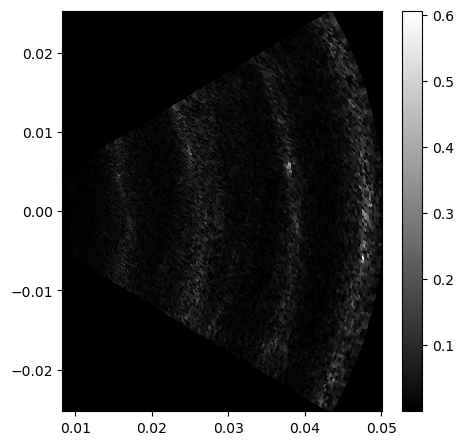

In [250]:
b = pymust.bmode(img_rec)
b = np.abs(img_rec)
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
cm = ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
cbar = plt.colorbar(cm)


/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_17752/3256029373.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(zdas, xdas , b,edgecolors='face', cmap = 'gray')


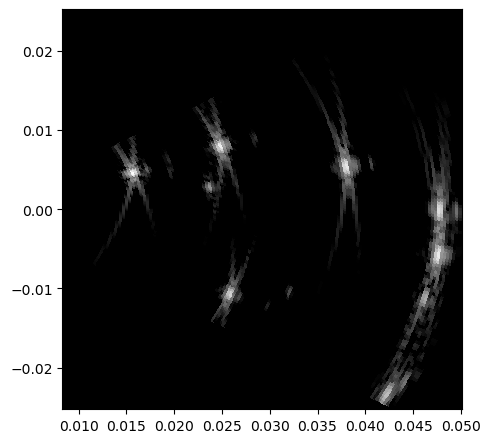

In [249]:
xdas,zdas = pymust.impolgrid(np.array([128, 128]),
                          5e-2, 
                          np.pi/3,
                          param)


Mdas = pymust.dasmtx(IQ_real,xdas,zdas, txdel, param)
IQb = (Mdas@IQ_real.flatten(order = 'F')).reshape(x.shape, order = 'F')

b = pymust.bmode(IQb)
#b = np.abs(IQb)
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
ax.pcolormesh(zdas, xdas , b,edgecolors='face', cmap = 'gray')
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
